# Test des criteres d'arret et de la complexite algo

In [1]:
# import different de ceux tout en haut pour ne rien toucher a ce qui marche
import numpy as np

import random

from collections import Counter

from math import floor,modf

from scipy.spatial.distance import cdist,mahalanobis
from scipy.stats import cauchy,chi2,mode

from KMOM import *

from sklearn import datasets
from sklearn.cluster import DBSCAN,Birch
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.datasets.samples_generator import make_blobs

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import time

# import skfuzzy as fuzz
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster import cluster_visualizer

In [2]:
def data_clustered_outliers(n_samples,n_outliers,p,centers = np.array([[1,4],[2,1],[-2,3]]),centers_outliers=np.array([[7,7]]),it_=None):
    if it_==None:
        it_=random.randint(a=0,b=10000)
    # initialisation des parametres
    centers=def_centers(mu=centers,p=p)
    centers_outliers=def_centers(mu=centers_outliers,p=p)
    K           = len(centers)              # nombre de classes
    sig         = 0.6                       # within variance
    # Generation des donnees
    Xinlier, y_inlier = make_blobs(n_samples=n_samples, centers=centers, cluster_std=0.60, random_state=it_)
    # Outliers creation
    Xoutlier, y_outlier = make_blobs(n_samples=n_outliers, centers=centers_outliers, cluster_std=0.60)
    # all concatenante
    n_data=n_samples+n_outliers
    X = np.concatenate([Xoutlier,Xinlier], axis=0)
    y_true=np.concatenate([y_outlier+K,y_inlier])
#     plt.plot(X[:,0],X[:,1],'b.')
    return({'points':X,'partition':y_true,"centers":centers})

def data_etalon_tclust(n,n_outliers,p,a=1,b=1,c=1,d=1,e=0,f=1,q1=1,q2=1,q3=1):
    # definir les effectifs dans chaque cluster
    n1=int(floor(n*q1/(q1+q2+q3)))
    n2=int(floor(n*q2/(q1+q2+q3)))
    n3=int(floor(n*q3/(q1+q2+q3)))
    # instanciation les centres en dimension p
    center_1=np.zeros((1,p))[0,:]
    center_2=np.zeros((1,p))[0,:]
    center_3=np.zeros((1,p))[0,:]
    # on leur donne les bonnes composantes
    center_1[1]=8
    center_2[0]=8
    center_3[0],center_3[1]=-8,-8
    centers=np.concatenate([[center_1,center_2,center_3]],axis=0)
    # instanciation des matrices de covariane en dimension p
    variance_1=np.identity(p)
    variance_2=np.identity(p)
    variance_3=np.identity(p)
    # on leur donne les bonnes composantes
    variance_1[1,1]=a
    variance_2[0,0]=b
    variance_2[1,1]=c
    variance_3[0,0]=d
    variance_3[0,1]=e
    variance_3[1,0]=e
    variance_3[1,1]=f
    # on genere les clusters
    C1=np.random.multivariate_normal(center_1, variance_1,n1)
    C2=np.random.multivariate_normal(center_2, variance_2,n2)
    C3=np.random.multivariate_normal(center_3, variance_3,n3)
    
    # on concatene les clusters pour avoir les donnees
    X=np.concatenate([C1,C2,C3])
    
    # on bruite les donnees
    lim_sup=X.max(axis=0)
    lim_inf=X.min(axis=0)
    amplitudes=lim_sup-lim_inf
    matrice_de_scaling=np.diag(amplitudes)
    # on ajoute les outliers 1 a 1
    list_outliers=[]
    while len(list_outliers)<n_outliers:
        # on genere un outlier dans le p-cube unite
        outlier_temp=np.random.uniform(0, 1, (1,p))[0,:]
        # on redimensionne le p-cube
        outlier=outlier_temp.dot(matrice_de_scaling)+lim_inf
        # on calcule les distances de mahalanobis de "outlier" aux differents centres pour leur matrices de cov respective.
        dist_mahalanobis_1=mahalanobis(outlier,center_1,np.linalg.inv(variance_1))**2
        dist_mahalanobis_2=mahalanobis(outlier,center_2,np.linalg.inv(variance_2))**2
        dist_mahalanobis_3=mahalanobis(outlier,center_3,np.linalg.inv(variance_3))**2
        # si "outlier" a moins de 2.5 pourcent de chance d'etre issue des gaussiennes prises separement alors on le prend.
        if min(dist_mahalanobis_1,dist_mahalanobis_2,dist_mahalanobis_3)>chi2.ppf(0.975, df=p):
            list_outliers.append(outlier)
            
            
    # on concatene pour avoir les donnees
    X_bruitee=np.concatenate([X,list_outliers])
    # la partition theorique
    partition_theorique_bruitee=np.concatenate([np.tile(0,n1),np.tile(1,n2),np.tile(2,n3),np.tile(-1,n_outliers)])
    
    return({'points':X_bruitee,'partition':partition_theorique_bruitee,"centers":centers})

## illustration of the "Remote Outliers" dataset

Remote_outliers_no=9_coeff=5_n=900


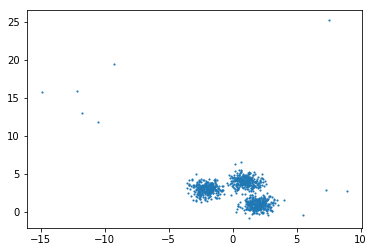

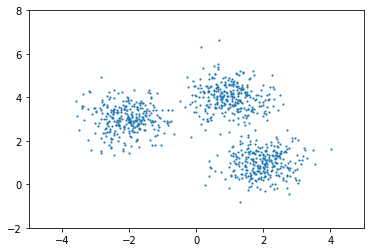

In [3]:
title_simu='Remote_outliers_no=9_coeff=5_n=900'
print(title_simu)
x                = 5
n_samples        = 900
n_outliers       = 9
n_data           = n_samples+n_outliers

mu = np.array([[1,4],[2,1],[-2,3]]) # class centers
init_cov_matrix = None
sig = 0.6 # within variance
K = len(mu)
max_iter=50
coef_ech=6
nb_blocs=251


list_temps_calcul=[]
# Generation des donnees      
X, y_true= make_blobs(n_samples=n_samples, centers=mu, cluster_std=0.60, random_state=20191104)

# Nb of outliers
X[:n_outliers,:] = x * X[:n_outliers,:]
y_true[:n_outliers] = -1
plt.scatter(X[:,0],X[:,1],marker='.',s=5)
plt.savefig('graph/'+title_simu+'whole.png')
plt.show()
plt.scatter(X[:,0],X[:,1],marker='.',s=5)
plt.xlim(-5,5)
plt.ylim(-2,8)
plt.savefig('graph/'+title_simu+'zoom.png')
plt.show()

# counter_debut=time.time()
# kmom      = KMOMalgo_unif(X=X,K=K,coef_ech=coef_ech,nbr_blocks=nb_blocs,outliers=n_outliers,max_iter=max_iter)
# res_kmom  = kmom.fit(X)
# y    = kmom.predict(X) # fitted clusters with kmom
# cent = res_kmom['Qb_centers'][-1] # fitted centroids in the initialisation step
# counter_fin=time.time()
# temps_calcul=counter_fin-counter_debut
# list_temps_calcul.append(temps_calcul)
# print(list_temps_calcul)
# print('')

## illustration of the "TClust" datasets

TClustSetting_noutliers=20_n=900

proportion_1st_cluster=1.0
proportion_2nd_cluster=1.0
proportion_3rd_cluster=1.0
dimensionality=2.0
anisotropy_1st_cluster___a=1.0
anisotropy_2nd_cluster___b=1.0
anisotropy_2nd_cluster___c=1.0
anisotropy_3rd_cluster___d=1.0
anisotropy_3rd_cluster___e=0.0
anisotropy_3rd_cluster___f=1.0


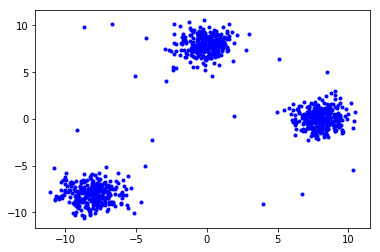

proportion_1st_cluster=1.0
proportion_2nd_cluster=1.0
proportion_3rd_cluster=1.0
dimensionality=2.0
anisotropy_1st_cluster___a=5.0
anisotropy_2nd_cluster___b=1.0
anisotropy_2nd_cluster___c=5.0
anisotropy_3rd_cluster___d=1.0
anisotropy_3rd_cluster___e=0.0
anisotropy_3rd_cluster___f=5.0


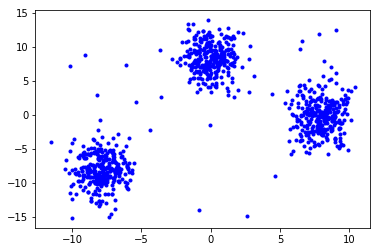

proportion_1st_cluster=1.0
proportion_2nd_cluster=1.0
proportion_3rd_cluster=1.0
dimensionality=2.0
anisotropy_1st_cluster___a=5.0
anisotropy_2nd_cluster___b=5.0
anisotropy_2nd_cluster___c=1.0
anisotropy_3rd_cluster___d=3.0
anisotropy_3rd_cluster___e=-2.0
anisotropy_3rd_cluster___f=3.0


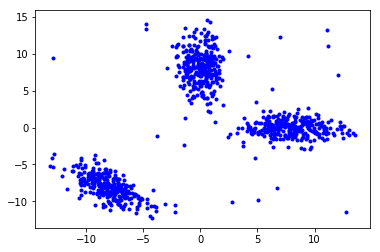

proportion_1st_cluster=1.0
proportion_2nd_cluster=1.0
proportion_3rd_cluster=1.0
dimensionality=2.0
anisotropy_1st_cluster___a=1.0
anisotropy_2nd_cluster___b=20.0
anisotropy_2nd_cluster___c=5.0
anisotropy_3rd_cluster___d=15.0
anisotropy_3rd_cluster___e=-10.0
anisotropy_3rd_cluster___f=15.0


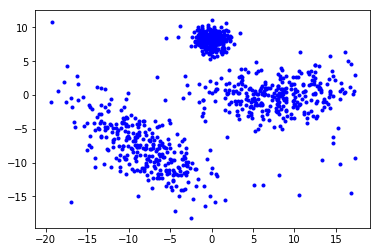

proportion_1st_cluster=1.0
proportion_2nd_cluster=1.0
proportion_3rd_cluster=1.0
dimensionality=2.0
anisotropy_1st_cluster___a=1.0
anisotropy_2nd_cluster___b=45.0
anisotropy_2nd_cluster___c=30.0
anisotropy_3rd_cluster___d=15.0
anisotropy_3rd_cluster___e=-10.0
anisotropy_3rd_cluster___f=15.0


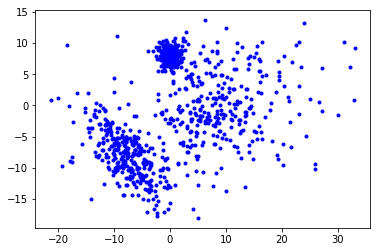

proportion_1st_cluster=1.0
proportion_2nd_cluster=2.0
proportion_3rd_cluster=2.0
dimensionality=2.0
anisotropy_1st_cluster___a=1.0
anisotropy_2nd_cluster___b=1.0
anisotropy_2nd_cluster___c=1.0
anisotropy_3rd_cluster___d=1.0
anisotropy_3rd_cluster___e=0.0
anisotropy_3rd_cluster___f=1.0


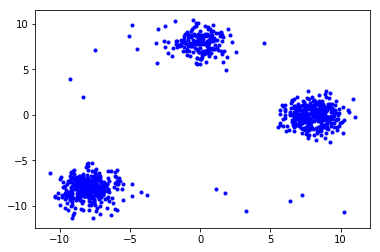

proportion_1st_cluster=1.0
proportion_2nd_cluster=2.0
proportion_3rd_cluster=2.0
dimensionality=2.0
anisotropy_1st_cluster___a=5.0
anisotropy_2nd_cluster___b=1.0
anisotropy_2nd_cluster___c=5.0
anisotropy_3rd_cluster___d=1.0
anisotropy_3rd_cluster___e=0.0
anisotropy_3rd_cluster___f=5.0


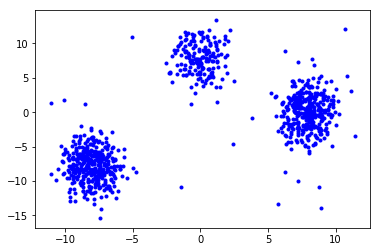

proportion_1st_cluster=1.0
proportion_2nd_cluster=2.0
proportion_3rd_cluster=2.0
dimensionality=2.0
anisotropy_1st_cluster___a=5.0
anisotropy_2nd_cluster___b=5.0
anisotropy_2nd_cluster___c=1.0
anisotropy_3rd_cluster___d=3.0
anisotropy_3rd_cluster___e=-2.0
anisotropy_3rd_cluster___f=3.0


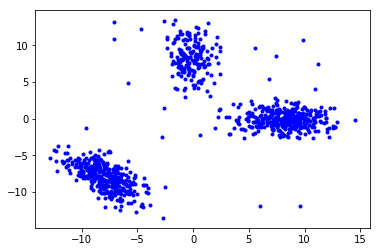

proportion_1st_cluster=1.0
proportion_2nd_cluster=2.0
proportion_3rd_cluster=2.0
dimensionality=2.0
anisotropy_1st_cluster___a=1.0
anisotropy_2nd_cluster___b=20.0
anisotropy_2nd_cluster___c=5.0
anisotropy_3rd_cluster___d=15.0
anisotropy_3rd_cluster___e=-10.0
anisotropy_3rd_cluster___f=15.0


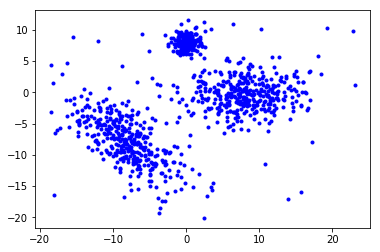

proportion_1st_cluster=1.0
proportion_2nd_cluster=2.0
proportion_3rd_cluster=2.0
dimensionality=2.0
anisotropy_1st_cluster___a=1.0
anisotropy_2nd_cluster___b=45.0
anisotropy_2nd_cluster___c=30.0
anisotropy_3rd_cluster___d=15.0
anisotropy_3rd_cluster___e=-10.0
anisotropy_3rd_cluster___f=15.0


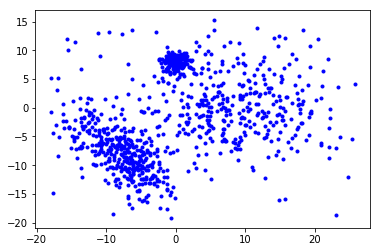

/home/jupyter/workspace/EdouardResearch/pour_mon_github/KMOM/algoKMOM_v8_4.py:283: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  D_nk_min_rows = D_nk[[np.arange(self.n).tolist(),partition_array.tolist()]]
/home/jupyter/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[0.7867679595947266]



In [9]:
# See here for sources : https://projecteuclid.org/download/pdfview_1/euclid.aos/1211819566 

title_simu='TClustSetting_noutliers=20_n=900'
print(title_simu)
print()

# parameter of the data set
n_inliers   = 900
n_outliers  = 20
n_samples   = n_inliers+n_outliers
K           = 3
proportion_array = np.array([[1,1,1],[1,2,2]]) # sets the size clusters compared to others # 
s1,s2 = proportion_array.shape
# print("proportion_array = \n"+str(proportion_array))

dim_array = np.array([2]) # sets the dimension of the data set                        # 2, 
s3 = dim_array.shape[0]
# print("dim_array = \n"+str(dim_array))

cov_prms_array = np.array([[1,1,1,1,0,1],[5,1,5,1,0,5],[5,5,1,3,-2,3],[1,20,5,15,-10,15],[1,45,30,15,-10,15]])
s5,s6 = cov_prms_array.shape
# print("cov_prms_array = \n"+str(cov_prms_array))

# gather parameters in an array
cases_array = np.ones( ( s1*s3*s5 , s2+1+s6 ))
i=0
for vq in proportion_array:
    for dim in dim_array:
        for vp in cov_prms_array:
            cases_array[i,0:s2] = vq
            cases_array[i,s2] = dim
            cases_array[i,(s2+1):(s2+s6+1)] = vp
            i=i+1
# print(cases_array)

# gather names of the situation in an array
cases_names = np.array(['NA']*s1*s3*s5*3).reshape((s1*s3*s5,3))
vec_prop_bool=proportion_array
cases_names[:,0] = np.repeat(a=(proportion_array.std(axis=1)==0).astype(str),repeats=s3*s5)
cases_names[:,1] = np.tile(A=np.repeat(a=dim_array.astype(str),repeats=s5),reps=s1)
cases_names[:,2] = np.tile(A=np.repeat(a=["M1","M2","M3","M4","M5"],repeats=1),reps=s1*s3)
component_names=["bal==","dim=",""]
# cases_names=np.apply_along_axis(arr=cases_names,axis=1,func1d=my_format_maker,component_names=component_names,sep='  ').flatten().tolist()
d1=len(cases_names)
        

# parameters for KMOM
nb_blocs = 251
coef_ech = 6
init_cov_matrix = None
max_iter=10
# parameters for kpdtm and kplm
q = 20
sig = 0.6 # within variance

for n_simu in range(len(cases_array)):
#     n_simu=3+5
    list_temps_calcul=[]
    # initialization of the data generation parameters
    q1,q2,q3,p,a,b,c,d,e,f = cases_array[n_simu]
#     print(cases_array[n_simu])
    print("proportion_1st_cluster="+str(q1))
    print("proportion_2nd_cluster="+str(q2))
    print("proportion_3rd_cluster="+str(q3))
    print("dimensionality="+str(p))
    print("anisotropy_1st_cluster___a="+str(a))
    print("anisotropy_2nd_cluster___b="+str(b))
    print("anisotropy_2nd_cluster___c="+str(c))
    print("anisotropy_3rd_cluster___d="+str(d))
    print("anisotropy_3rd_cluster___e="+str(e))
    print("anisotropy_3rd_cluster___f="+str(f))
    # data generation
    temp = data_etalon_tclust(n=n_inliers,n_outliers=n_outliers,p=int(p),a=a,b=b,c=c,d=d,e=e,f=f,q1=q1,q2=q2,q3=q3)
    X = temp["points"][::-1]
    y_true = temp["partition"][::-1]
    centers = temp["centers"]
    plt.plot(X[:,0],X[:,1],'b.')
    plt.savefig('graph/'+title_simu+'case_'+str(n_simu)+'.png')
    plt.show()

counter_debut = time.time()
kmom      = KMOMalgo_unif(X=X,K=K,coef_ech=coef_ech,nbr_blocks=nb_blocs,outliers=n_outliers,max_iter=max_iter)
res_kmom  = kmom.fit(X)
y    = kmom.predict(X) # fitted clusters with kmom
cent = res_kmom['Qb_centers'][-1] # fitted centroids in the initialisation step
counter_fin=time.time()
temps_calcul=counter_fin-counter_debut
list_temps_calcul.append(temps_calcul)
print(list_temps_calcul)
print('')